# DRUMS - COVASIM Data Generation

In [1]:
import sys
sys.path.append('../')
from drums_data_gen import *

Covasim 3.1.3 (2022-07-19) — © 2020-2022 by IDM


***

- `test_prob`: This is a float value that corresponds to the probability of testing given the agent is symptomatic. Currently, the values for proabbility of testing for other scenarios are `asymp_prob=0.001`, `symp_quar_prob=0.3`, and `asymp_quar_prob=0.3`. Additionally, the policy for quarantining is `quar_policy='daily'`
- `trace_lb` and `trace_ub`: These float values correspond to the lower and upper bounds on probability of tracing. Currently, the trace probability for the layers are `h=1.0`, `s=0.5`, `w=0.5`, `c=0.3`.
- `chi_type`: The type of the function that interacts with the tracing probability. Can choose between `constant`, `linear`, `piecewise`, and `sin`.
- `dynamic`: Boolean value that indicates whether or not to include the interacting term/function.
- `keep_d`: Boolean value that indicates wehter or not to include the D - diagnosed compartments.
- `model_params:` Dictionary containing keys pointing to parameter values, the compartment model's values over the simulation, and more.

In [2]:
population = int(50e3)
test_prob = 0.1
trace_lb = 0.0
trace_ub = 0.3
chi_type = 'constant'
keep_d = True
dynamic = True
model_params = ModelParams(population, test_prob, trace_lb, trace_ub, chi_type, keep_d, dynamic)

Initializing sim with 50000 people for 182 days
  Running 2020-02-01 ( 0/182) (1.68 s)  ———————————————————— 1%
  Running 2020-02-11 (10/182) (2.18 s)  •——————————————————— 6%
  Running 2020-02-21 (20/182) (2.72 s)  ••—————————————————— 11%
  Running 2020-03-02 (30/182) (3.15 s)  •••————————————————— 17%
  Running 2020-03-12 (40/182) (3.62 s)  ••••———————————————— 22%
  Running 2020-03-22 (50/182) (4.11 s)  •••••——————————————— 28%
  Running 2020-04-01 (60/182) (4.61 s)  ••••••—————————————— 33%
  Running 2020-04-11 (70/182) (5.12 s)  •••••••————————————— 39%
  Running 2020-04-21 (80/182) (5.68 s)  ••••••••———————————— 44%
  Running 2020-05-01 (90/182) (6.19 s)  •••••••••——————————— 50%
  Running 2020-05-11 (100/182) (6.79 s)  •••••••••••————————— 55%
  Running 2020-05-21 (110/182) (7.35 s)  ••••••••••••———————— 61%
  Running 2020-05-31 (120/182) (7.86 s)  •••••••••••••——————— 66%
  Running 2020-06-10 (130/182) (8.35 s)  ••••••••••••••—————— 72%
  Running 2020-06-20 (140/182) (8.86 s) 

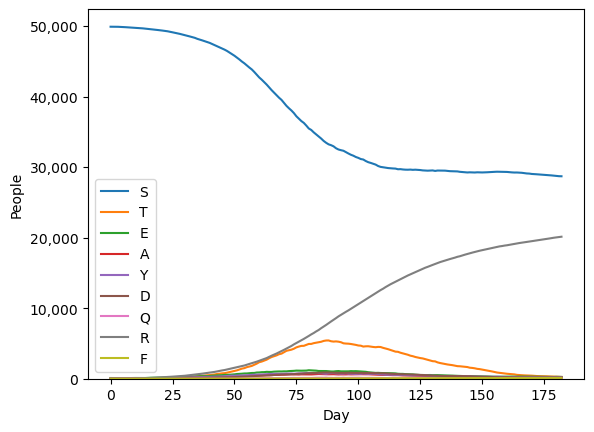

In [3]:
drums_data_generator(model_params)